# American Sign Language Detection

## 1 Introduction and Setup

### 1.1 Module Imports

In [2]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from packaging import version
import io
import itertools

# Sklearn Imports
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV

# Keras and Tensorflow imports
import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Load the TensorBoard notebook extension and related libraries
import datetime, os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)


# tensorboard(
#     logs_base_dir,
#     reload_multifile = True,
#     reload_interval = 5
# )

### 1.2 Data Import

In [3]:
train = pd.read_csv('data/sign_mnist_train.csv')
test = pd.read_csv('data/sign_mnist_test.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
train.shape, test.shape

((27455, 785), (7172, 785))

### 1.3 Data Distribution Visualization

<Axes: ylabel='count'>

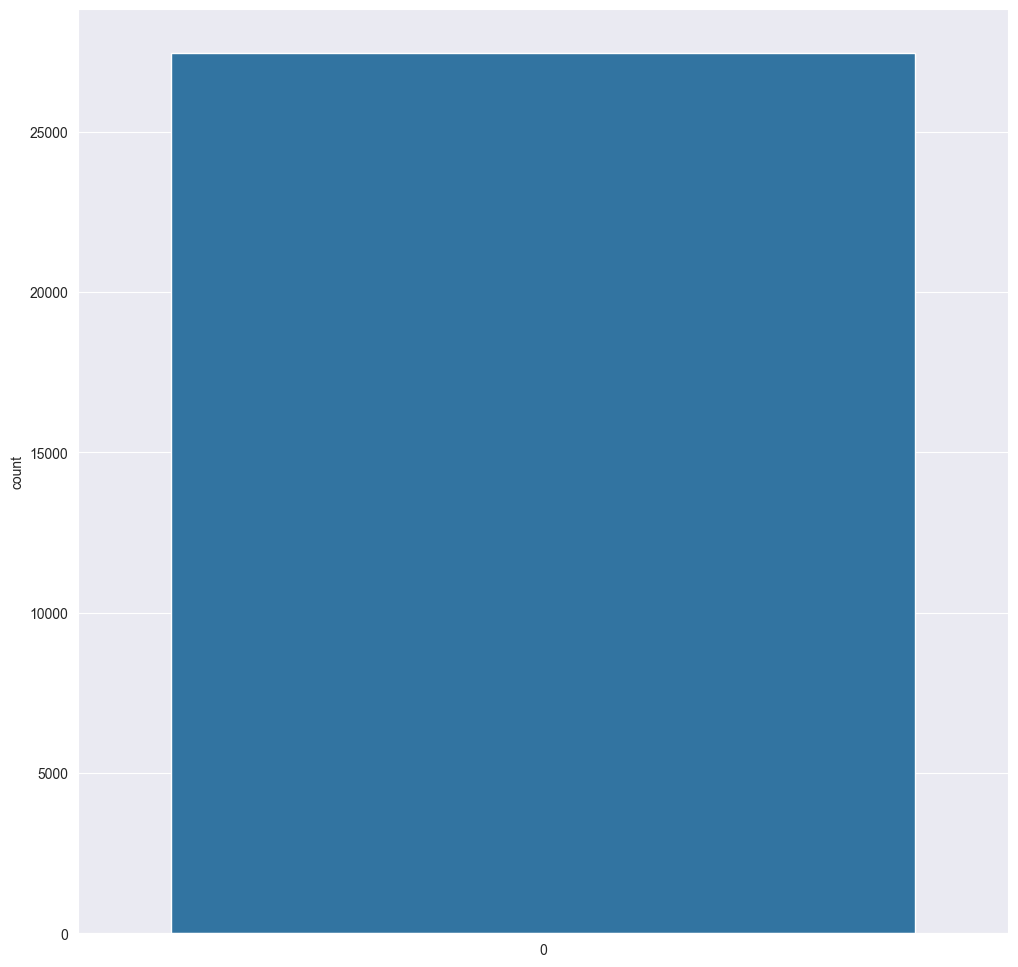

In [6]:
plt.figure(figsize=(12,12))
sns.set_style('darkgrid')
sns.countplot(train['label'])

### 1.4 Data Preprocessing

In [7]:
y_train = train['label']
y_test = test['label']

X_train = train.drop('label', axis=1)
X_test = test.drop('label', axis=1)

In [8]:
# Normalization of input data to 0-1 scale
X_train /= 255
X_test /= 255

In [9]:
#Binarization of the Data

labeller = LabelBinarizer()
y_train = labeller.fit_transform(y_train)
y_test = labeller.fit_transform(y_test)

In [10]:
# reshape the data (downsampling)

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

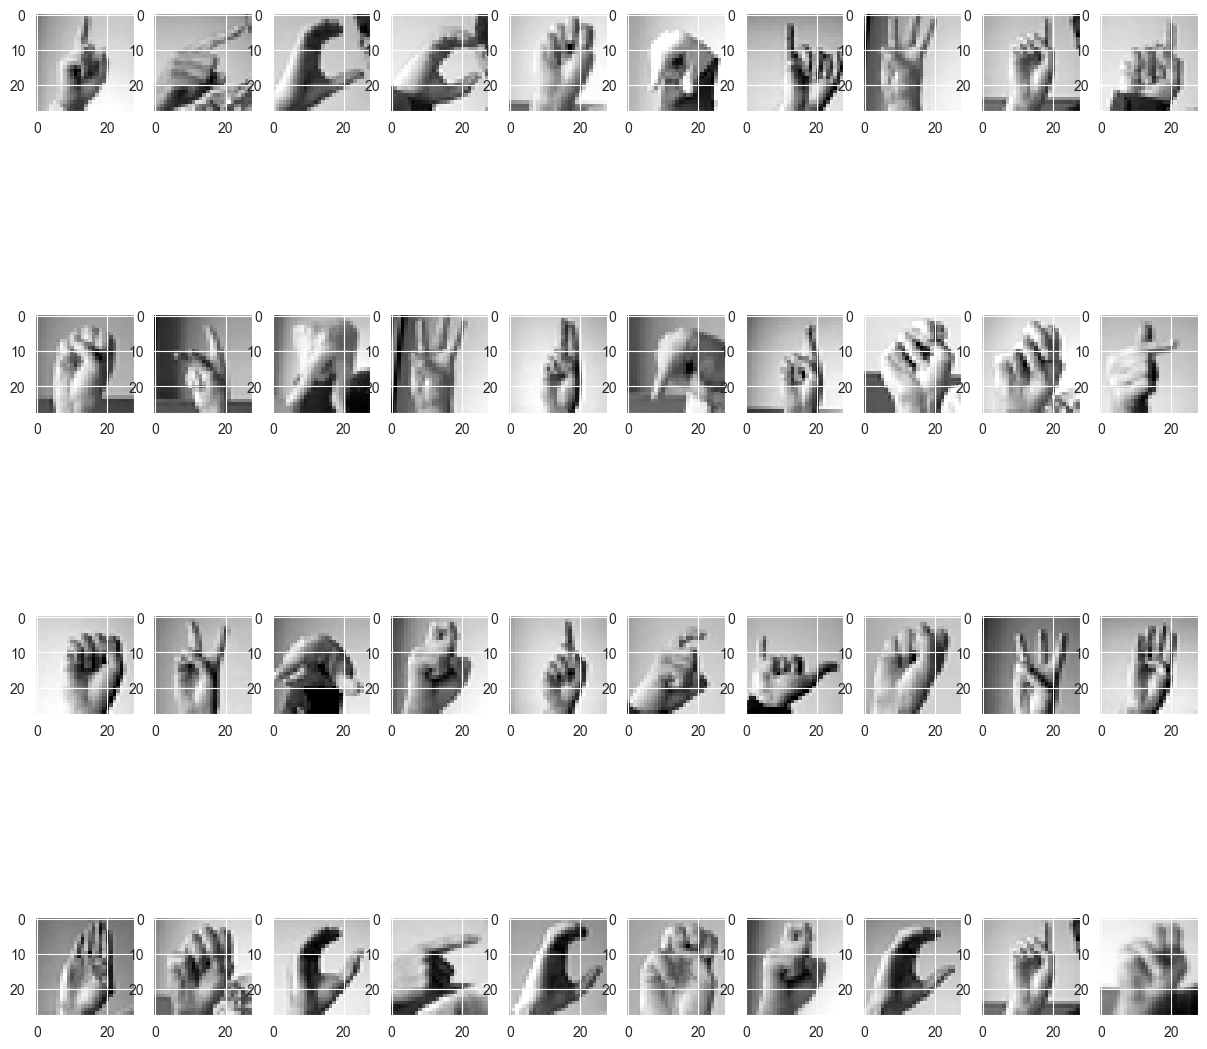

In [11]:
# Displayig some example images
plt.figure(figsize=(15,15))

x = 10
y = 4
for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')

plt.show()

In [12]:
data_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=.1,
    width_shift_range=.1,
    height_shift_range=.1,
    horizontal_flip=False,
    vertical_flip=False
)

data_generator.fit(X_train)

In [13]:
learning_rate = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=1, 
    factor=.5, 
    min_lr=.00001
)

In [14]:
model_1 = Sequential()
model_1.add(Conv2D(20,
                  kernel_size=(3,3),
                  activation='tanh',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_1.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_1.add(Conv2D(30,
                  kernel_size=(3,3),
                  activation='tanh',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))


model_1.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_1.add(Flatten())
model_1.add(Dense(units=24, activation='softmax'))

In [15]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 30)        5430      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 30)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1470)              0         
                                                                 
 dense (Dense)               (None, 24)                3

In [18]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.
 
  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
 
  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
 
  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
 
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

class_names =["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

def plot_to_image(figure):
  """Converts the matplotlib plot to a PNG image and returns it.
  The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  print(image.shape)
  image = tf.expand_dims(image, 0)
  return image

# Sets up a timestamped log directory
logdir = "logs/image_2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Create file Writer for Confusion Metrics
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model_1.predict(X_test)
  test_pred = np.argmax(test_pred_raw, axis=1)
  y_test_cls = np.argmax(y_test, axis=1)
 
  # Calculate the confusion matrix.
  cm = confusion_matrix(y_test_cls, test_pred)
 
  figure = plot_confusion_matrix(cm, class_names=class_names)
  cm_image = plot_to_image(figure)
 
  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)
 
# Define the per-epoch callback to plot confusion metrics after each epoch.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [19]:
%tensorboard --logdir logs/image_2 --reload_multifile True --reload_interval 5

history = model_1.fit(data_generator.flow(X_train, y_train, batch_size=128), 
                    epochs=10, 
                    # verbose=0, # Suppress chatty output and use Tensorboard instead
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard_callback, cm_callback],
                    )

Reusing TensorBoard on port 6006 (pid 26212), started 0:02:24 ago. (Use '!kill 26212' to kill it.)

Epoch 1/10
225/225 [==============================] - 2s 9ms/step
(800, 800, 4)
215/215 [==============================] - 26s 122ms/step - loss: 0.3121 - accuracy: 0.9117 - val_loss: 0.1532 - val_accuracy: 0.9653
Epoch 2/10
225/225 [==============================] - 2s 9ms/step
(800, 800, 4)
215/215 [==============================] - 27s 128ms/step - loss: 0.2539 - accuracy: 0.9292 - val_loss: 0.1398 - val_accuracy: 0.9738
Epoch 3/10
 77/215 [=========>....................] - ETA: 12s - loss: 0.2318 - accuracy: 0.9364

KeyboardInterrupt: 

In [19]:
print("Accuracy: ", model_1.evaluate(X_test, y_test)[1]*100, "%")

225/225 [==============================] - 2s 9ms/step - loss: 0.0857 - accuracy: 0.9842
Accuracy:  98.42442870140076 %


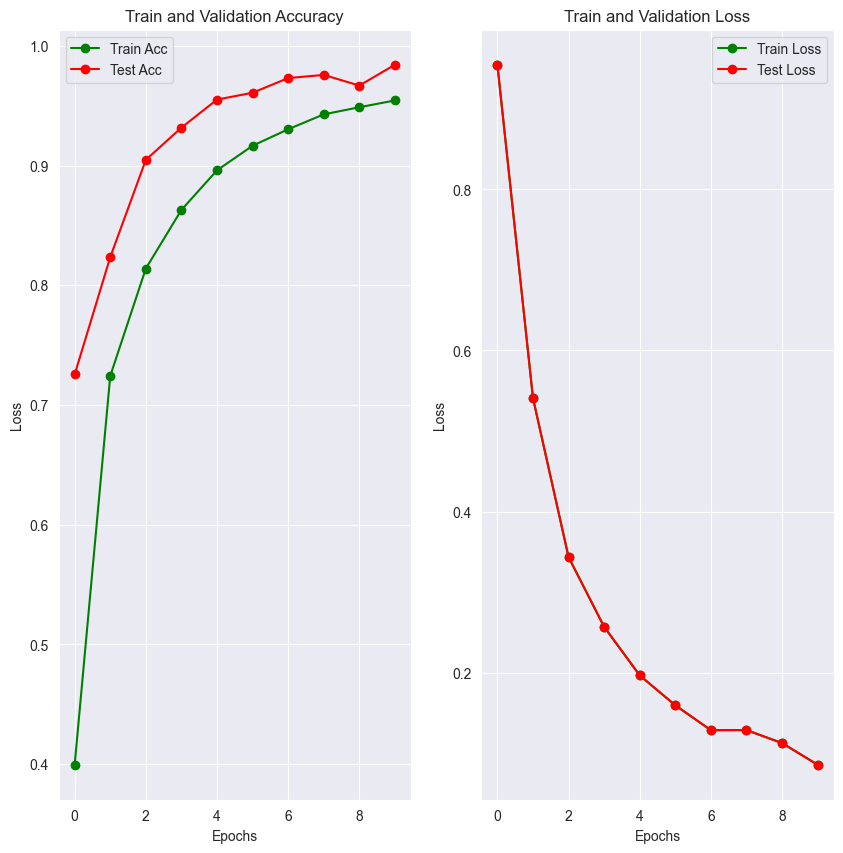

In [20]:
epochs = [i for i in range(10)]

fig,ax= plt.subplots(1,2)
train_acc= history.history['accuracy']
train_loss= history.history['loss']
vall_acc= history.history['val_accuracy']
vall_loss=history.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, vall_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, vall_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, vall_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [21]:
# Adjusting the size of the Conv2D layers
model_2 = Sequential()
model_2.add(Conv2D(25,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_2.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_2.add(Conv2D(35,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))


model_2.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_2.add(Flatten())
model_2.add(Dense(units=24, activation='softmax'))

In [22]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 25)        250       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 25)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 35)        7910      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 35)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1715)              0         
                                                                 
 dense_1 (Dense)             (None, 24)               

In [23]:
history_2 = model_2.fit(data_generator.flow(X_train, y_train, batch_size=128), 
                    epochs=10, 
                    validation_data=(X_test, y_test),
                    # callbacks=[learning_rate]
                    )

Epoch 1/10
215/215 [==============================] - 25s 106ms/step - loss: 2.1944 - accuracy: 0.3657 - val_loss: 0.9163 - val_accuracy: 0.7359
Epoch 2/10
215/215 [==============================] - 25s 115ms/step - loss: 0.9421 - accuracy: 0.7087 - val_loss: 0.5859 - val_accuracy: 0.7913
Epoch 3/10
215/215 [==============================] - 31s 145ms/step - loss: 0.6402 - accuracy: 0.8010 - val_loss: 0.3886 - val_accuracy: 0.8675
Epoch 4/10
215/215 [==============================] - 26s 119ms/step - loss: 0.4790 - accuracy: 0.8530 - val_loss: 0.2469 - val_accuracy: 0.9225
Epoch 5/10
215/215 [==============================] - 27s 123ms/step - loss: 0.3776 - accuracy: 0.8845 - val_loss: 0.2541 - val_accuracy: 0.9260
Epoch 6/10
 65/215 [========>.....................] - ETA: 18s - loss: 0.3236 - accuracy: 0.9035

: 

: 

In [ ]:
print("Accuracy: ", model_2.evaluate(X_test, y_test)[1]*100, "%")

225/225 [==============================] - 1s 6ms/step - loss: 0.0766 - accuracy: 0.9796
Accuracy:  97.96430468559265 %


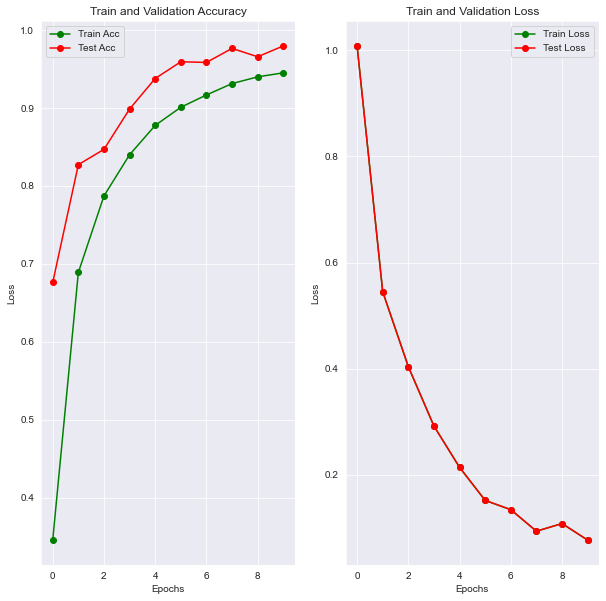

In [ ]:
epochs = [i for i in range(10)]

fig,ax= plt.subplots(1,2)
train_acc= history_2.history['accuracy']
train_loss= history_2.history['loss']
vall_acc= history_2.history['val_accuracy']
vall_loss=history_2.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, vall_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, vall_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, vall_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
# Adjusting the model to include normalization and dropout
model_3 = Sequential()
model_3.add(Conv2D(30,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_3.add(BatchNormalization())

model_3.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_3.add(Conv2D(40,
                  kernel_size=(3,3),
                  activation='relu',
                  input_shape=(28,28,1),
                  strides=1,
                  padding='same'
                  ))

model_3.add(Dropout(.2))
model_3.add(BatchNormalization())

model_3.add(MaxPool2D(pool_size=(3,3),
                      strides=2,
                      padding='same'
                      ))

model_3.add(Flatten())
model_3.add(Dense(units=24, activation='softmax'))

In [ ]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 30)        300       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 30)        120       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 40)        10840     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 40)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 40)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 40)         

In [ ]:
history_3 = model_3.fit(data_generator.flow(X_train, y_train, batch_size=128), 
                        epochs=10, 
                        validation_data=(X_test, y_test), 
                        callbacks=[learning_rate])

Epoch 1/10
215/215 [==============================] - 29s 133ms/step - loss: 1.1200 - accuracy: 0.6676 - val_loss: 2.6268 - val_accuracy: 0.1128
Epoch 2/10
215/215 [==============================] - 28s 132ms/step - loss: 0.3077 - accuracy: 0.9004 - val_loss: 1.0154 - val_accuracy: 0.7256
Epoch 3/10
215/215 [==============================] - 29s 133ms/step - loss: 0.1730 - accuracy: 0.9452 - val_loss: 0.2280 - val_accuracy: 0.9230
Epoch 4/10
215/215 [==============================] - 28s 132ms/step - loss: 0.1235 - accuracy: 0.9605 - val_loss: 0.2142 - val_accuracy: 0.9236
Epoch 5/10
215/215 [==============================] - 29s 137ms/step - loss: 0.0899 - accuracy: 0.9710 - val_loss: 0.1177 - val_accuracy: 0.9702
Epoch 6/10
215/215 [==============================] - 29s 133ms/step - loss: 0.0737 - accuracy: 0.9752 - val_loss: 0.1257 - val_accuracy: 0.9582
Epoch 7/10
215/215 [==============================] - 29s 135ms/step - loss: 0.0620 - accuracy: 0.9797 - val_loss: 0.0678 - val_ac

In [ ]:
print("Accuracy of the model is: ", model_3.evaluate(X_test, y_test)[1]*100, '%')

225/225 [==============================] - 1s 7ms/step - loss: 0.0297 - accuracy: 0.9940
Accuracy of the model is:  99.4004487991333 %


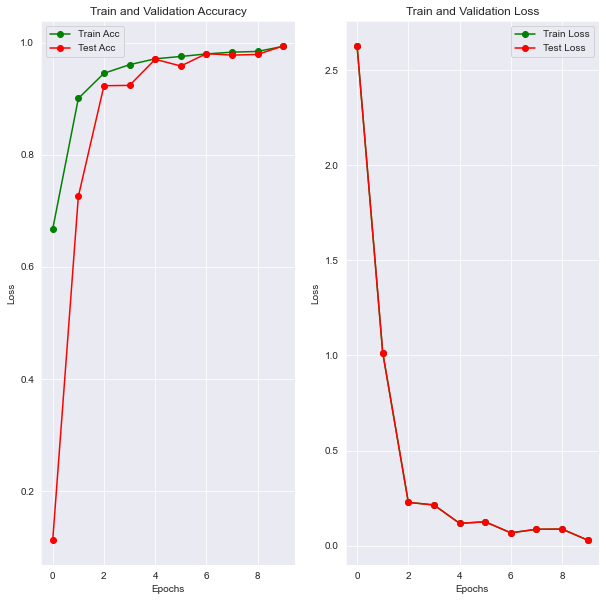

In [ ]:
epochs = [i for i in range(10)]

fig,ax= plt.subplots(1,2)
train_acc= history_3.history['accuracy']
train_loss= history_3.history['loss']
vall_acc= history_3.history['val_accuracy']
vall_loss=history_3.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, vall_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, vall_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, vall_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()